In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [58]:
from scipy.linalg import block_diag

In [59]:
plt.close("all")

In [60]:
data = "../data/robot_data.csv"


In [61]:
df = pd.read_csv(data,header=None, names=['wheel_l','wheel_r','beta_l','beta_r','alpha', 'i', 'j'])

In [62]:
df

,wheel_l,wheel_r,beta_l,beta_r,alpha,i,j
0,4.339037,5.222191,-0.081213,-0.028580,0.000000,0.0,0.0
1,7.985567,9.541640,0.256569,0.389239,0.000000,0.0,1.0
2,29.423655,30.394486,1.649905,1.732968,0.000000,0.0,2.0
3,12.761680,14.964949,0.361553,0.549626,0.000000,2.0,2.0
4,2.322680,4.732295,-0.061688,0.002664,-0.010590,2.0,2.0
...,...,...,...,...,...,...,...
8305,4.486822,3.544922,0.004759,-0.004447,0.000000,2.0,1.0
8306,4.542530,5.012943,-0.006072,0.005130,0.000000,2.0,0.0
8307,5.693855,9.232214,-0.016103,0.022271,-0.027125,1.0,0.0
8308,8.609503,8.689882,0.006894,-0.009138,-0.001944,0.0,0.0


In [63]:
i_filter = 1
j_filter = 0

In [64]:
filtered = df[(df.i == i_filter) & (df.j == j_filter)]
filtered

# filtered = df
# filtered

,wheel_l,wheel_r,beta_l,beta_r,alpha,i,j
184,5.045506,8.647794,-0.017502,0.021673,-0.030077,1.0,0.0
189,5.693804,9.232234,-0.016203,0.022134,-0.027398,1.0,0.0
194,6.831158,9.513143,-0.012312,0.015879,-0.016583,1.0,0.0
253,5.048041,8.647728,-0.017783,0.021551,-0.029797,1.0,0.0
258,5.695350,9.231703,-0.016133,0.022359,-0.026944,1.0,0.0
...,...,...,...,...,...,...,...
8253,5.045590,8.647789,-0.017542,0.021673,-0.029820,1.0,0.0
8258,5.693855,9.232214,-0.016282,0.022085,-0.027155,1.0,0.0
8263,6.831182,9.513110,-0.012468,0.015787,-0.016580,1.0,0.0
8302,5.045590,8.647789,-0.017735,0.021752,-0.029941,1.0,0.0


In [65]:
x = filtered[['wheel_l','wheel_r']].values
y = filtered[['beta_l','beta_r','alpha']].values

In [66]:
import seaborn as sns

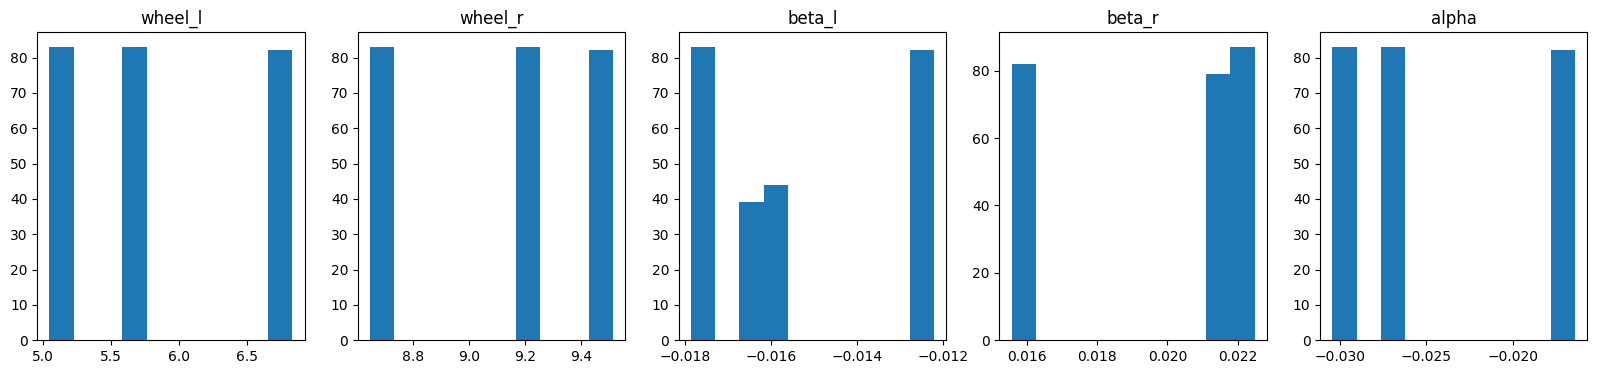

In [67]:
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
ax[0].hist(x[..., 0])
ax[0].set_title('wheel_l')
ax[1].hist(x[..., 1])
ax[1].set_title('wheel_r')
# %% plot histogram to see if output distribution is well behaved, to see if it is neeeded a scaling
ax[2].hist(y[..., 0])
ax[2].set_title('beta_l')
ax[3].hist(y[..., 1])
ax[3].set_title('beta_r')
ax[4].hist(y[..., 2])
ax[4].set_title('alpha')
plt.show()

In [68]:
# Example data
omega_l = filtered.wheel_l.values
omega_r = filtered.wheel_r.values
beta_l = filtered.beta_l.values
beta_r = filtered.beta_r.values
alpha = filtered.alpha.values
Y = np.column_stack((beta_l, beta_r, alpha))

# Initial OLS regression to get residuals
X = np.column_stack((np.ones(len(omega_l)), omega_l, omega_r))
theta_hat_ols = np.linalg.inv(X.T @ X) @ (X.T @ Y)
y_hat_ols = X @ theta_hat_ols
residuals_ols = Y - y_hat_ols

# Estimate weights as the inverse of the squared residuals
weights_l = 1 / (residuals_ols[:, 0] ** 2 + 1e-10) 
weights_r = 1 / (residuals_ols[:, 1] ** 2 + 1e-10) 
weights_alpha = 1 / (residuals_ols[:, 2] ** 2 + 1e-10) 

# Create individual diagonal weight matrices for each output
W_l = np.diag(weights_l)
W_r = np.diag(weights_r)
W_alpha = np.diag(weights_alpha)

# Combine these into a block diagonal matrix
W = block_diag(W_l, W_r, W_alpha)

# Expand X to match the block diagonal structure
X_expanded = np.kron(np.eye(3), X)  # Kronecker product to create the expanded X matrix

# Now compute WLS using the expanded X and Y
XTWX_inv = np.linalg.inv(X_expanded.T @ W @ X_expanded)
XTWy = X_expanded.T @ W @ Y.flatten(order='F')
theta_hat_wls_flat = XTWX_inv @ XTWy

# Reshape the result back to the original coefficient shape
theta_hat_wls = theta_hat_wls_flat.reshape(3, -1).T

# Estimated coefficients from WLS
theta_0, theta_1, theta_2 = theta_hat_wls
print("WLS Estimated coefficients:", theta_hat_wls)


WLS Estimated coefficients: [[-0.02319745 -0.02497758 -0.02036458]
 [ 0.00365193 -0.00821042  0.01100247]
 [-0.00148962  0.01017855 -0.00751721]]


In [69]:
X.shape

(248, 3)

In [70]:
y_hat_wls = X @ theta_hat_wls

In [71]:
residuals_wls = Y - y_hat_wls

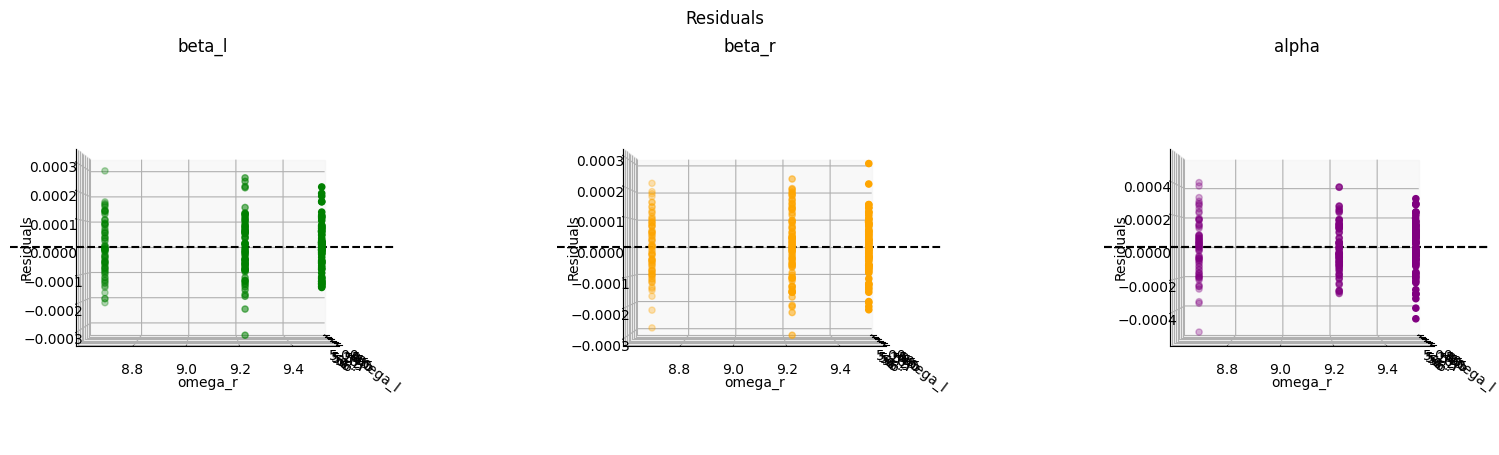

In [72]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 5))
fig.suptitle("Residuals")

# Beta_l residuals
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(omega_l, omega_r, residuals_ols[...,0], color="green")
bound = max(abs(residuals_ols[...,0].min()),abs(residuals_ols[...,0].max()))
ax1.set_zlim(-bound,bound)
ax1.axhline(0, linestyle='--', color="black")
ax1.set_xlabel("omega_l")
ax1.set_ylabel("omega_r")
ax1.set_zlabel("Residuals")
ax1.set_title("beta_l")
ax1.view_init(0, 0, 0)

# Beta_r residuals
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(omega_l, omega_r, residuals_ols[...,1], color="orange")
bound = max(abs(residuals_ols[...,1].min()),abs(residuals_ols[...,1].max()))
ax2.set_zlim(-bound,bound)
ax2.axhline(0, linestyle='--', color="black")
ax2.set_xlabel("omega_l")
ax2.set_ylabel("omega_r")
ax2.set_zlabel("Residuals")
ax2.set_title("beta_r")
ax2.view_init(0, 0, 0)

# Alpha residuals
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(omega_l, omega_r, residuals_ols[...,2], color="purple")
bound = max(abs(residuals_ols[...,2].min()),abs(residuals_ols[...,2].max()))
ax3.set_zlim(-bound,bound)
ax3.axhline(0, linestyle='--', color="black")
ax3.axhline(0, linestyle='--', color="black")
ax3.set_xlabel("omega_l")
ax3.set_ylabel("omega_r")
ax3.set_zlabel("Residuals")
ax3.set_title("alpha")
ax3.view_init(0, 0, 0)

plt.show()


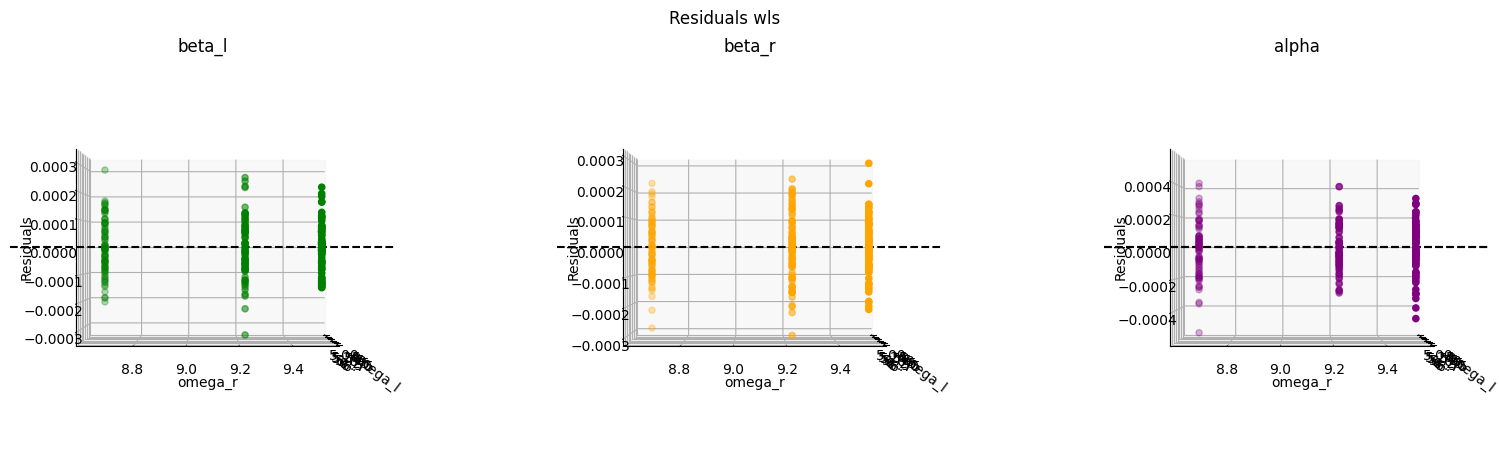

In [73]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 5))
fig.suptitle("Residuals wls")

# Beta_l residuals
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(omega_l, omega_r, residuals_wls[...,0], color="green")
bound = max(abs(residuals_ols[...,0].min()),abs(residuals_ols[...,0].max()))
ax1.set_zlim(-bound,bound)
ax1.axhline(0, linestyle='--', color="black")
ax1.set_xlabel("omega_l")
ax1.set_ylabel("omega_r")
ax1.set_zlabel("Residuals")
ax1.set_title("beta_l")
ax1.view_init(0, 0, 0)

# Beta_r residuals
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(omega_l, omega_r, residuals_wls[...,1], color="orange")
bound = max(abs(residuals_ols[...,1].min()),abs(residuals_ols[...,1].max()))
ax2.set_zlim(-bound,bound)
ax2.axhline(0, linestyle='--', color="black")
ax2.set_xlabel("omega_l")
ax2.set_ylabel("omega_r")
ax2.set_zlabel("Residuals")
ax2.set_title("beta_r")
ax2.view_init(0, 0, 0)

# Alpha residuals
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(omega_l, omega_r, residuals_wls[...,2], color="purple")
bound = max(abs(residuals_ols[...,2].min()),abs(residuals_ols[...,2].max()))
ax3.set_zlim(-bound,bound)
ax3.axhline(0, linestyle='--', color="black")
ax3.axhline(0, linestyle='--', color="black")
ax3.set_xlabel("omega_l")
ax3.set_ylabel("omega_r")
ax3.set_zlabel("Residuals")
ax3.set_title("alpha")
ax3.view_init(0, 0, 0)

plt.show()


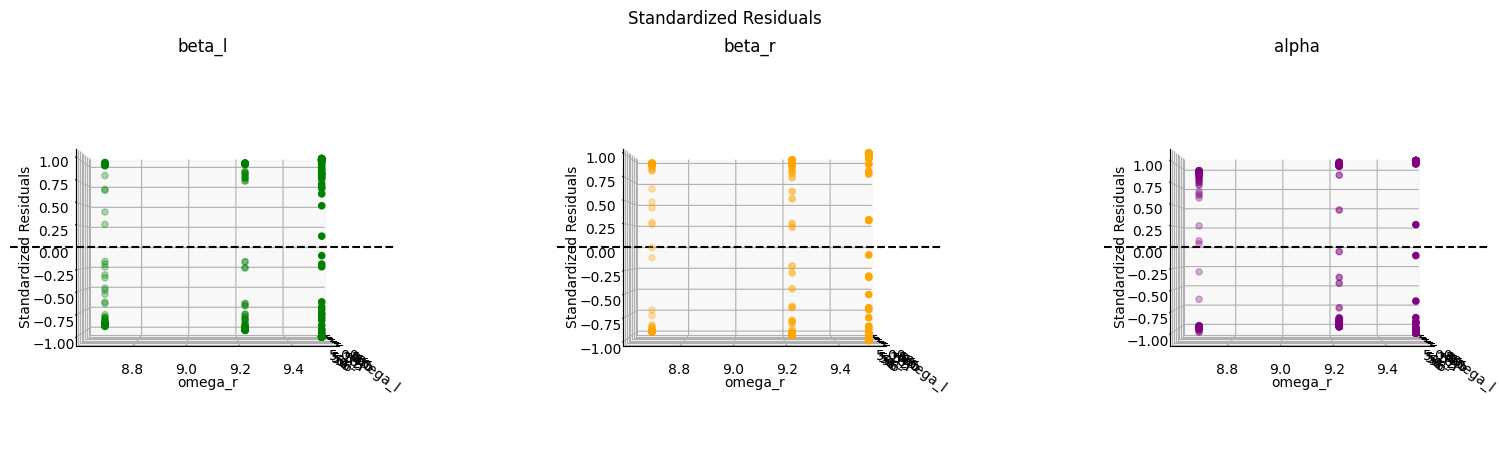

In [74]:
# The standard deviation for each residual is sqrt(1 / weight)
std_residuals_l = residuals_wls[:, 0] * np.sqrt(weights_l)
std_residuals_r = residuals_wls[:, 1] * np.sqrt(weights_r)
std_residuals_alpha = residuals_wls[:, 2] * np.sqrt(weights_alpha)

# Step 3: Plot the standardized residuals
fig = plt.figure(figsize=(20, 5))
fig.suptitle("Standardized Residuals")

# Beta_l standardized residuals
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(omega_l, omega_r, std_residuals_l, color="green")
bound = max(abs(std_residuals_l.min()),abs(std_residuals_l.max()))
ax1.set_zlim(-bound,bound)
ax1.axhline(0, linestyle='--', color="black")
ax1.set_xlabel("omega_l")
ax1.set_ylabel("omega_r")
ax1.set_zlabel("Standardized Residuals")
ax1.set_title("beta_l")
ax1.view_init(0, 0, 0)


# Beta_r standardized residuals
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(omega_l, omega_r, std_residuals_r, color="orange")
bound = max(abs(std_residuals_r.min()),abs(std_residuals_r.max()))
ax2.set_zlim(-bound,bound)
ax2.axhline(0, linestyle='--', color="black")
ax2.set_xlabel("omega_l")
ax2.set_ylabel("omega_r")
ax2.set_zlabel("Standardized Residuals")
ax2.set_title("beta_r")
ax2.view_init(0, 0, 0)

# Alpha standardized residuals
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(omega_l, omega_r, std_residuals_alpha, color="purple")
bound = max(abs(std_residuals_alpha.min()),abs(std_residuals_alpha.max()))
ax3.set_zlim(-bound,bound)
ax3.axhline(0, linestyle='--', color="black")
ax3.set_xlabel("omega_l")
ax3.set_ylabel("omega_r")
ax3.set_zlabel("Standardized Residuals")
ax3.set_title("alpha")
ax3.view_init(0, 0, 0)

plt.show()

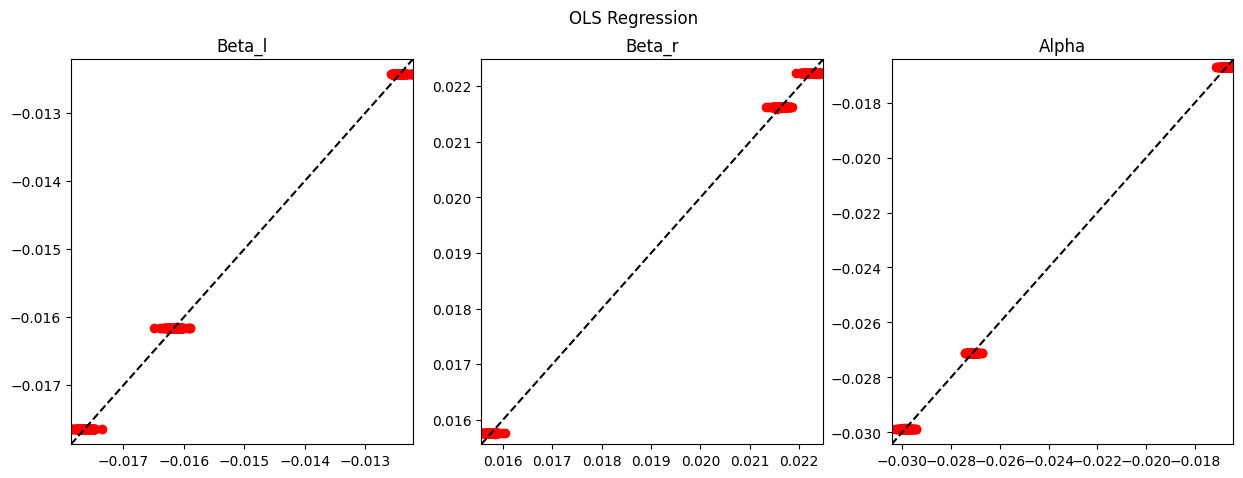

In [75]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("OLS Regression")
# fig.suptitle('Horizontally stacked subplots')
# Beta_l
y_min = min(Y[...,0].min(),y_hat_ols[...,0].min())
y_max = max(Y[...,0].max(),y_hat_ols[...,0].max())
ax[0].set_title("Beta_l")
ax[0].set_xlim(y_min,y_max)
ax[0].set_ylim(y_min,y_max)
ax[0].scatter(Y[...,0],y_hat_ols[...,0], color="red")
ax[0].plot([y_min,y_max],[y_min,y_max], "--", color='black')
# Beta_r
y_min = min(Y[...,1].min(),y_hat_ols[...,1].min())
y_max = max(Y[...,1].max(),y_hat_ols[...,1].max())
ax[1].set_title("Beta_r")
ax[1].set_xlim(y_min,y_max)
ax[1].set_ylim(y_min,y_max)
ax[1].scatter(Y[...,1],y_hat_ols[...,1], color="red")
ax[1].plot([y_min,y_max],[y_min,y_max], "--", color='black')
# Alpha
y_min = min(Y[...,2].min(),y_hat_ols[...,2].min())
y_max = max(Y[...,2].max(),y_hat_ols[...,2].max())
ax[2].set_title("Alpha")
ax[2].set_xlim(y_min,y_max)
ax[2].set_ylim(y_min,y_max)
ax[2].scatter(Y[...,2],y_hat_ols[...,2], color="red")
ax[2].plot([y_min,y_max],[y_min,y_max], "--", color='black')
plt.show()

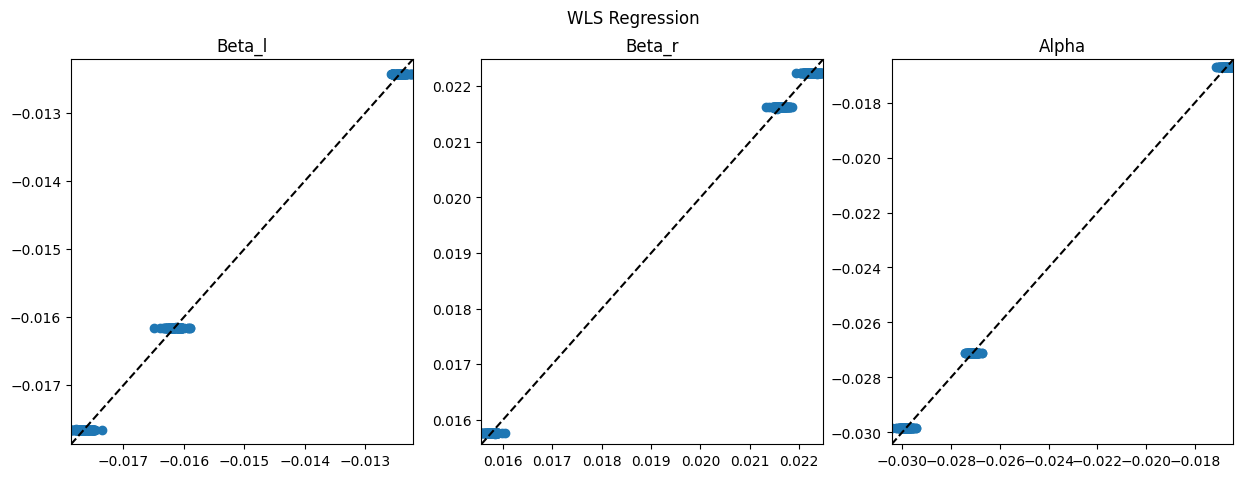

In [76]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("WLS Regression")
# fig.suptitle('Horizontally stacked subplots')
# Beta_l
y_min = min(Y[...,0].min(),y_hat_wls[...,0].min())
y_max = max(Y[...,0].max(),y_hat_wls[...,0].max())
ax[0].set_title("Beta_l")
ax[0].set_xlim(y_min,y_max)
ax[0].set_ylim(y_min,y_max)
ax[0].scatter(Y[...,0],y_hat_wls[...,0])
ax[0].plot([y_min,y_max],[y_min,y_max], "--", color='black')
# Beta_r
y_min = min(Y[...,1].min(),y_hat_wls[...,1].min())
y_max = max(Y[...,1].max(),y_hat_wls[...,1].max())
ax[1].set_title("Beta_r")
ax[1].set_xlim(y_min,y_max)
ax[1].set_ylim(y_min,y_max)
ax[1].scatter(Y[...,1],y_hat_wls[...,1])
ax[1].plot([y_min,y_max],[y_min,y_max], "--", color='black')
# Alpha
y_min = min(Y[...,2].min(),y_hat_wls[...,2].min())
y_max = max(Y[...,2].max(),y_hat_wls[...,2].max())
ax[2].set_title("Alpha")
ax[2].set_xlim(y_min,y_max)
ax[2].set_ylim(y_min,y_max)
ax[2].scatter(Y[...,2],y_hat_wls[...,2])
ax[2].plot([y_min,y_max],[y_min,y_max], "--", color='black')
plt.show()

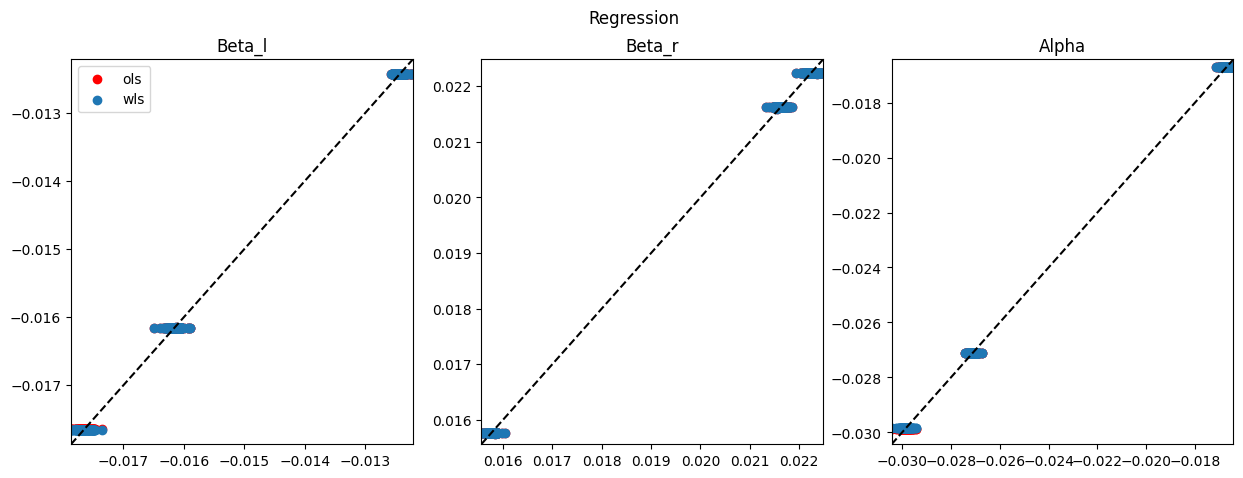

In [77]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Regression")
# fig.suptitle('Horizontally stacked subplots')
# Beta_l
y_min = min(Y[...,0].min(),y_hat_ols[...,0].min())
y_max = max(Y[...,0].max(),y_hat_ols[...,0].max())
ax[0].set_title("Beta_l")
ax[0].set_xlim(y_min,y_max)
ax[0].set_ylim(y_min,y_max)
ax[0].scatter(Y[...,0],y_hat_ols[...,0], color="red", label="ols")
ax[0].scatter(Y[...,0],y_hat_wls[...,0], label="wls")
ax[0].plot([y_min,y_max],[y_min,y_max], "--", color='black')
ax[0].legend()
# Beta_r
y_min = min(Y[...,1].min(),y_hat_ols[...,1].min())
y_max = max(Y[...,1].max(),y_hat_ols[...,1].max())
ax[1].set_title("Beta_r")
ax[1].set_xlim(y_min,y_max)
ax[1].set_ylim(y_min,y_max)
ax[1].scatter(Y[...,1],y_hat_ols[...,1], color="red")
ax[1].scatter(Y[...,1],y_hat_wls[...,1])
ax[1].plot([y_min,y_max],[y_min,y_max], "--", color='black')
# Alpha
y_min = min(Y[...,2].min(),y_hat_ols[...,2].min())
y_max = max(Y[...,2].max(),y_hat_ols[...,2].max())
ax[2].set_title("Alpha")
ax[2].set_xlim(y_min,y_max)
ax[2].set_ylim(y_min,y_max)
ax[2].scatter(Y[...,2],y_hat_ols[...,2], color="red")
ax[2].scatter(Y[...,2],y_hat_wls[...,2])
ax[2].plot([y_min,y_max],[y_min,y_max], "--", color='black')
plt.show()

In [78]:
r2_score(Y, y_hat_wls), r2_score(Y, y_hat_ols)

(0.9986139291133519, 0.9986143538644696)

In [79]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Extract coefficients from WLS estimation
theta_0_l, theta_1_l, theta_2_l = theta_hat_wls[:, 0]  # Coefficients for beta_l
theta_0_r, theta_1_r, theta_2_r = theta_hat_wls[:, 1]  # Coefficients for beta_r
theta_0_alpha, theta_1_alpha, theta_2_alpha = theta_hat_wls[:, 2]  # Coefficients for alpha

# Create a grid of values for omega_l and omega_r
omega_l_grid, omega_r_grid = np.meshgrid(np.linspace(omega_l.min(), omega_l.max(), 100),
                                         np.linspace(omega_r.min(), omega_r.max(), 100))

# Calculate the corresponding beta_l, beta_r, and alpha values on the grid
beta_l_grid = theta_0_l + theta_1_l * omega_l_grid + theta_2_l * omega_r_grid
beta_r_grid = theta_0_r + theta_1_r * omega_l_grid + theta_2_r * omega_r_grid
alpha_grid = theta_0_alpha + theta_1_alpha * omega_l_grid + theta_2_alpha * omega_r_grid


In [80]:
# %matplotlib tk

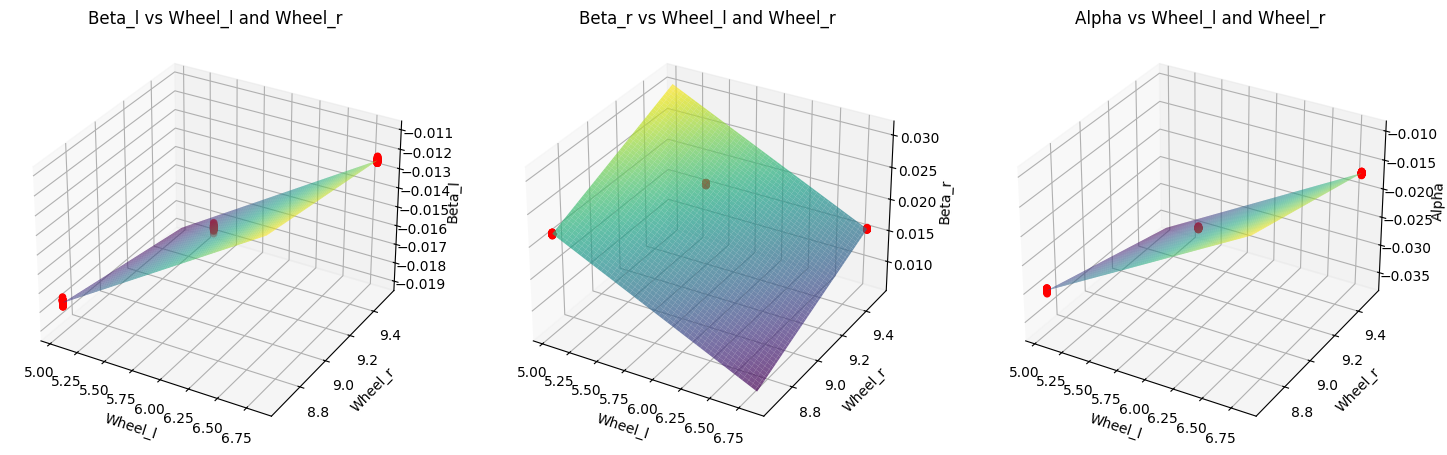

In [81]:
fig = plt.figure(figsize=(18, 6))

# Beta_l surface
ax = fig.add_subplot(131, projection='3d')
ax.plot_surface(omega_l_grid, omega_r_grid, beta_l_grid, cmap=cm.viridis, alpha=0.7)
ax.scatter(omega_l, omega_r, beta_l, color='red')  # Original data points
ax.set_title('Beta_l vs Wheel_l and Wheel_r')
ax.set_xlabel('Wheel_l')
ax.set_ylabel('Wheel_r')
ax.set_zlabel('Beta_l')

# Beta_r surface
ax = fig.add_subplot(132, projection='3d')
ax.plot_surface(omega_l_grid, omega_r_grid, beta_r_grid, cmap=cm.viridis, alpha=0.7)
ax.scatter(omega_l, omega_r, beta_r, color='red')  # Original data points
ax.set_title('Beta_r vs Wheel_l and Wheel_r')
ax.set_xlabel('Wheel_l')
ax.set_ylabel('Wheel_r')
ax.set_zlabel('Beta_r')

# Alpha surface
ax = fig.add_subplot(133, projection='3d')
ax.plot_surface(omega_l_grid, omega_r_grid, alpha_grid, cmap=cm.viridis, alpha=0.7)
ax.scatter(omega_l, omega_r, alpha, color='red')  # Original data points
ax.set_title('Alpha vs Wheel_l and Wheel_r')
ax.set_xlabel('Wheel_l')
ax.set_ylabel('Wheel_r')
ax.set_zlabel('Alpha')

plt.show()


In [83]:
%matplotlib tk

In [84]:
fig = plt.figure(figsize=(18, 6))

# Beta_l surface
ax = fig.add_subplot(131, projection='3d')
ax.plot_surface(omega_l_grid, omega_r_grid,
                beta_l_grid, cmap=cm.viridis, alpha=0.7)
ax.scatter(omega_l, omega_r, beta_l, color='red')  # Original data points
ax.set_title('Beta_l vs Wheel_l and Wheel_r')
ax.set_xlabel('Wheel_l')
ax.set_ylabel('Wheel_r')
ax.set_zlabel('Beta_l')
ax.view_init(30, 75, 0)

# Beta_r surface
ax = fig.add_subplot(132, projection='3d')
ax.plot_surface(omega_l_grid, omega_r_grid,
                beta_r_grid, cmap=cm.viridis, alpha=0.7)
ax.scatter(omega_l, omega_r, beta_r, color='red')  # Original data points
ax.set_title('Beta_r vs Wheel_l and Wheel_r')
ax.set_xlabel('Wheel_l')
ax.set_ylabel('Wheel_r')
ax.set_zlabel('Beta_r')
ax.view_init(30, 75, 0)

# Alpha surface
ax = fig.add_subplot(133, projection='3d')
ax.plot_surface(omega_l_grid, omega_r_grid,
                alpha_grid, cmap=cm.viridis, alpha=0.7)
ax.scatter(omega_l, omega_r, alpha, color='red')  # Original data points
ax.set_title('Alpha vs Wheel_l and Wheel_r')
ax.set_xlabel('Wheel_l')
ax.set_ylabel('Wheel_r')
ax.set_zlabel('Alpha')
ax.view_init(30, 75, 0)

plt.show()